# AutoEncoder

## Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

## Seeding for reproducibility

In [38]:
np.random.seed(421)
torch.random.manual_seed(421)

## Dataset Loading

In [83]:
batch_size = 64
data_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
train_dataset = datasets.MNIST(root='MNIST_AE', download=True, train=True, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_dataset = datasets.MNIST(root='MNIST_AE', download=True, train=False, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False,num_workers=2)

## AutoEncoder Class

In [47]:
class AE(nn.Module):
    def __init__(self,in_features):
        super().__init__()
        
        self.nn1 = nn.Linear(in_features,392)
        self.nn2 = nn.Linear(392,196)
        self.nn3 = nn.Linear(196,392)
        self.nn4 = nn.Linear(392,in_features)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        

    def forward(self,x):
        x = self.relu(self.nn1(x))
        x = self.sigmoid(self.nn2(x))
        x = self.relu(self.nn3(x))
        x = self.tanh(self.nn4(x))
        return x

## Hyperparameters

In [48]:
#Config 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:',device)
device = torch.device(device)
num_epoch = 5
lr = 2e-4

Device: cuda


## Model instance

In [49]:
images,labels=next(iter(train_loader))
in_features = images.shape[2]*images.shape[3]
model = AE(in_features=in_features).to(device)

## Loss function and Optimizer

In [50]:
#Loss and Optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


## Training Loop

In [51]:
#Training
model.train()
for epoch in range(num_epoch):
    total_loss = 0
    for (images,_) in train_loader:
        images = images.to(device)
        images = images.reshape(-1,in_features)
        preds = model(images)
        loss = criterion(preds, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch:[{epoch}/{num_epoch}], Reconstruction Loss:{total_loss/len(train_loader)}")

Epoch:[0/5], Reconstruction Loss:0.1677763103199666
Epoch:[1/5], Reconstruction Loss:0.07148357914057749
Epoch:[2/5], Reconstruction Loss:0.0533105459834721
Epoch:[3/5], Reconstruction Loss:0.04407567515778643
Epoch:[4/5], Reconstruction Loss:0.037815839945793406


## Helper functions- Plotting 

In [52]:
def plot_images(image_grid,title):
    plt.figure(figsize=(8, 2))
    plt.imshow(image_grid,cmap='gray')
    plt.title(title)

def reshape_images(images):
    images = torch.stack([image.reshape(1,28,28) for image in images])
    return torch.cat([tensor for tensor in images],dim=2)

## Model Evaluation

Test 0


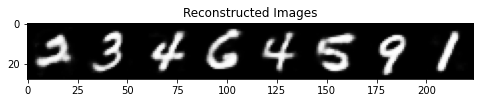

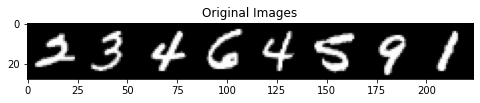

In [53]:
model.eval()
for idx in range(1):
    print(f"Test {idx}")
    with torch.no_grad():
        images,_ = next(iter(test_loader))
        images = images.reshape(-1,in_features).to(device)
        preds = model(images)

        images = reshape_images(images)*0.5 + 0.5
        preds = reshape_images(preds)*0.5 + 0.5

        plot_images(preds[0].cpu(),'Reconstructed Images')
        plot_images(images[0].cpu(),'Original Images')
        

In [108]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [109]:
model.nn3.register_forward_hook(get_activation('nn3'))
print(activation)
images,_ = next(iter(test_loader))
images = images.reshape(-1,in_features).to(device)
output = model(images)

{}


In [110]:
def plot_images_hook(image_grid,title):
    plt.figure(figsize=(8, 2))
    plt.imshow(image_grid,cmap='gray')
    plt.title(f'Activations for Linear Layer {title}')

def reshape_images_hook(images):
    images = torch.stack([image.reshape(1,28,14) for image in images])
    return torch.cat([tensor for tensor in images],dim=2)


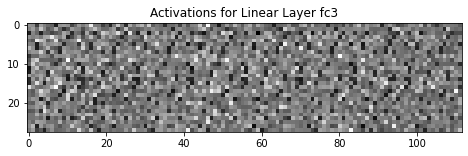

In [111]:
act = activation['nn3']
act = reshape_images_hook(act)
plot_images_hook(act[0].cpu(),'fc3')